# Welcome to ID of MBL

We have assembled the code neccessary for repuducing our plots from the paper

The code is presented in 5 sections:

1. EigenComponent Dominance
2. [Optional]: Problem sketch: intuition for what ID is?
3. "How to go from eigenstate to ID"-figure, with subplot with 2NN fit
4. ID Scaling Collapse -> inset in not-collapsed
5. !! fig 4: 2NN degen. mitigation

## 0. Notes
* The notebook should be self-contained (w/ import utils.py) ... or does it have to be?

In [55]:
# packages
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from utils import *

## 1. Problem Sketch
If we have points laying in a 3-dimensional coordinate system but confined to a plane, the extrinsic dim. is 3 but the intrinsic dim. is 2.

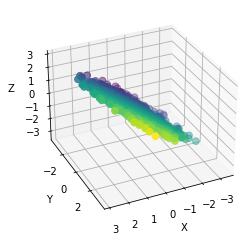

In [50]:
num_points = 1000
x, y = np.random.randn(num_points), np.random.randn(num_points)
z = x

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z, c=y, s=45)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(30, 65)
plt.show()

## 2. EigenComponent Dominance
We may investigate whether there is a change in intrinsic dimension across the phase transition by looking at the weight distribution within eigenvectors. A decrease in intrinsic dimension is indicated by a consolidation of weight in an eigenvector.

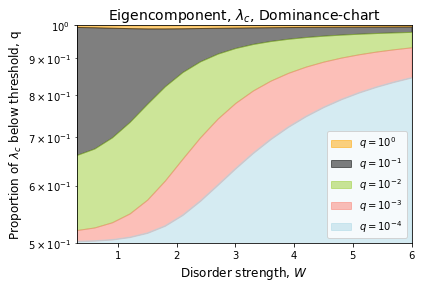

In [51]:
num_seeds = 10

data = []
L = 12
for start_seed in np.arange(0,1000,num_seeds):
    
    filename = 'initial_results/L_{}_seeds{}_{}.npy'.format(L, start_seed, start_seed+10)
    one_file = np.load(filename)
    data.append(one_file)
    
data = np.array(data)



avgs = np.mean(data, axis=0)
np.shape(data), np.shape(avgs)
avgs.T
avg_with_0_1 = np.vstack([np.ones(20), avgs.T, np.zeros(20)])
avg_with_0_1

ws = [0.3, 0.6, 0.8999999999999999, 1.2,  1.5, 1.8,
                      2.0999999999999996, 2.4, 2.6999999999999997, 
                      2.9999999999999996, 3.3, 3.5999999999999996, 
                      3.8999999999999995, 4.2, 4.5, 4.8, 5.1, 
                      5.3999999999999995, 5.699999999999999, 6.0]


# plt stacked lines
colors = 'orange, lightblue, salmon, yellowgreen, black, orange'.split(', ')[::-1]
i = 1
for i, color in zip(range(len(avg_with_0_1)-1),colors):
    a = i*(-1)
    plt.fill_between(ws, avg_with_0_1[i], avg_with_0_1[i+1], 
                        label='$q=10^{}$'.format({a}),
                       color=color, alpha=.5)
    
        
plt.legend(loc='lower right')
plt.yscale('log')
#plt.yticks(np.arange(0.5,1.1,0.1), [0.5,0.6,0.7,0.8,0.9,1.0])
plt.xlim(min(ws), max(ws))
plt.ylim(0.5, 1)

plt.xlabel('Disorder strength, $W$', fontsize=12)
plt.ylabel('Proportion of $\lambda_c$ below threshold, q', fontsize=12)
plt.title('Eigencomponent, $\lambda_c$, Dominance-chart', fontsize=14)

plt.savefig('figures/Domination-chart.png', dpi=500, bbox_inches='tight')

## 3. 2NN
2NN is a neighbour graph algo. which determines the intrinsic dimension of a dataset -- when applied to a list of eigenvectors corresponding to one realization of a single disorder strength.

Additionally we determine quality of the fit!

## 4. 2NN averaging
By performing 2NN on eigenvectors from many disorder strengths and averaging across many realization, we obtain a general trend. 

We can improve results by including a weight when averaging. The weight is determined by the quality of individual 2NN fits.

## 5. Scaling collapse
To obtain the critical disorder strength, we may collapse the fits from **4.**

### 5.1. Scaling Template

see: https://pyfssa.readthedocs.io/en/stable/tutorial.html

/Users/antongolles/opt/anaconda3/lib/python3.7/site-packages/fssa/fssa.py:505: RuntimeWarning:

invalid value encountered in sqrt



quality: 0.7934653615810405 ... dunno what this means?


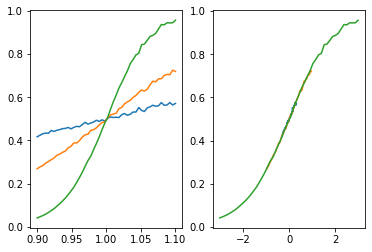

In [60]:
# generate artificial scaling data from master curve
# with rho_c == 1.0, nu == 2.0, zeta == 0.0
import fssa
import numpy as np
import matplotlib.pyplot as plt
l = [ 10, 100, 1000 ]
rho = np.linspace(0.9, 1.1)
l_mesh, rho_mesh = np.meshgrid(l, rho, indexing='ij')
master_curve = lambda x: 1. / (1. + np.exp( - x))
x = np.power(l_mesh, 0.5) * (rho_mesh - 1.)
y = master_curve(x)
dy = y / 100.
y += np.random.randn(*y.shape) * dy # add noise
a = y
da = dy
# run autoscale
res = fssa.autoscale(l=l, rho=rho, a=a, da=da, rho_c0=0.9, nu0=2.0, zeta0=0.0)

fig , ax = plt.subplots(1,2)

for index, L in enumerate(l):
    ax[0].plot(rho, y[index])

scaled = fssa.scaledata(l=l, rho=rho, a=a, da=da, rho_c=res['rho'], nu=res['nu'], zeta=res['zeta'])
X = scaled[0]
Y = scaled[1]
for index, L in enumerate(l):
    ax[1].plot(X[index], Y[index])
    
    
quality = fssa.quality(X,Y,da)
print('quality:', quality, '... dunno what this means?')

### 5.2. Scaling MBL data

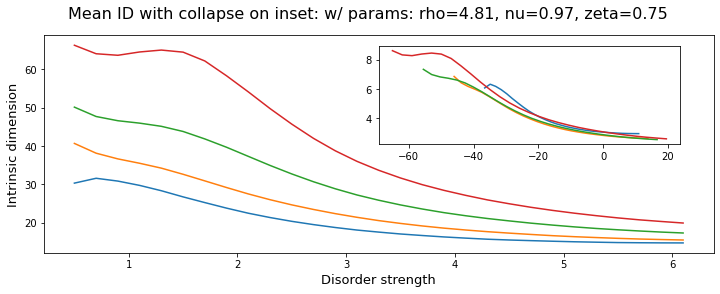

1.2741116331838618


In [74]:
def open_means():
	Data = []
	for i in [8,10,12,14]:
		file_name = 'fullresults/2nn-{}-combined_mean.npy'.format(i)
		data = np.load(file_name, allow_pickle=True)
		Data.append(data)
	return np.array(Data)

l = [8,10,12,14]
ws = np.linspace(0.1,6.1, 31)

a = open_means()

skip_initial = 2
a = a[:,skip_initial:]
ws = ws[skip_initial:]
da = a / 100

res = fssa.autoscale(l=l, rho=ws, a=a, da=da, rho_c0=3.5, nu0=2., zeta0=2.)

fig, ax = plt.subplots(figsize=(12,4))


for index, L in enumerate(l):
    ax.plot(ws, a[index])

ax.set_xlabel('Disorder strength', fontsize=13)
ax.set_ylabel('Intrinsic dimension', fontsize=13)
axin = ax.inset_axes([0.5, 0.5, 0.45, 0.45])

#print(res)
scaled = fssa.scaledata(l=l, rho=ws, a=a, da=da, rho_c=res['rho'], nu=res['nu'], zeta=res['zeta'])
X = scaled[0]
Y = scaled[1]
#plt.figure()
for index, L in enumerate(l):
    axin.plot(X[index], Y[index])
    
quality = fssa.quality(X,Y,da)
fig.suptitle('Mean ID with collapse on inset: w/ params: rho={}, nu={}, zeta={}'. format(round(res['rho'],2), 
                                                                               round(res['nu'],2), 
                                                                                round(res['zeta'],2)),
            fontsize=16)

plt.show()
print(quality)

### 5.3 Lets try this with an interactive function as to figure out the best setting of params

In [76]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [93]:
l = [8,10,12,14]


def scale_collapse(rho_c0=3.5, nu0=2., zeta0=2., skip_initial = 2, drop_ls = 0):
    l = [8,10,12,14]
    ws = np.linspace(0.1,6.1, 31)
    l = l[drop_ls:]
    a = open_means()
    a = a[drop_ls:,skip_initial:]
    ws = ws[skip_initial:]
    da = a / 100

    res = fssa.autoscale(l=l, rho=ws, a=a, da=da, rho_c0=rho_c0, nu0=nu0, zeta0=zeta0)

    fig, ax = plt.subplots(figsize=(12,4))

    for index, L in enumerate(l):
        ax.plot(ws, a[index])

    ax.set_xlabel('Disorder strength', fontsize=13)
    ax.set_ylabel('Intrinsic dimension', fontsize=13)
    axin = ax.inset_axes([0.5, 0.5, 0.45, 0.45])

    #print(res)
    scaled = fssa.scaledata(l=l, rho=ws, a=a, da=da, rho_c=res['rho'], nu=res['nu'], zeta=res['zeta'])
    X = scaled[0]
    Y = scaled[1]
    #plt.figure()
    for index, L in enumerate(l):
        axin.plot(X[index], Y[index])

    quality = fssa.quality(X,Y,da)
    fig.suptitle('Mean ID with collapse on inset: w/ params: rho={}, nu={}, zeta={}'. format(round(res['rho'],2), 
                                                                                   round(res['nu'],2), 
                                                                                    round(res['zeta'],2)), fontsize=16)

    plt.show()


In [94]:
interact(scale_collapse,rho_c0=3.5, nu0=2., zeta0=2., skip_initial = 2, drop_ls = 0);

interactive(children=(FloatSlider(value=3.5, description='rho_c0', max=10.5, min=-3.5), FloatSlider(value=2.0,…

## 6. Degeneracy issue mitigation
* does it have to be the **nearest** neighbours?

In [90]:
a[1:,1:].shape

(3, 30)